In [62]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" #HEADER_LEN,X_DIM,Y_DIM,X_left_boundry,X_right_boundry,Y_left_boundry,Y_right_boundry
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" # frame rate, shutter delay, and interseted position 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers

In [63]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam"

In [64]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)
velocity_list

[3, 21, 10, 42, 4]


[['103.8'], ['17.6'], ['35.3'], ['8.8'], ['88.2']]

In [65]:
gold_melting_W = {
    '103.8': 98.5,
    '17.6': 64,
    '35.3': 73.5,
    '8.8': 61.5,
    '88.2': 93.5
}

In [66]:
v_list = ['103.8', '17.6', '35.3', '8.8', '88.2']
Dict_1 = dict((k, fivemm_files[k][3:]) for k in v_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

In [67]:
power_used = {
        '103.8':[65+5*p for p in range(0,len(dRoverR_1[v_list.index('103.8')]),1)], 
        '17.6':[30+5*p for p in range(0,len(dRoverR_1[v_list.index('17.6')]),1)], 
        '35.3':[40+5*p for p in range(0,len(dRoverR_1[v_list.index('35.3')]),1)],
        '8.8':[30+5*p for p in range(0,len(dRoverR_1[v_list.index('8.8')]),1)], 
        '88.2':[55+5*p for p in range(0,len(dRoverR_1[v_list.index('88.2')]),1)],
          
        }


In [74]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                
        #convert the frame number to position
        #x = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] 
        
        x = [frame for frame in range(0,len(dR_list))] 
        
        
        plt.plot(x, dR_list, marker="o")
        
        #limit temperature to 1500C
        #plt.ylim(0,1500)
        
        #limit position to 1-10mm
        #plt.xlim(0,5)

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

  0%|          | 0/300 [00:00<?, ?it/s]/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 30%|███       | 91/300 [00:00<00:00, 424.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_006.raw
/Users/chiaentsai/Library/CloudSto

 33%|███▎      | 98/300 [00:19<00:54,  3.72it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_008.raw


 33%|███▎      | 99/300 [00:26<01:20,  2.49it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_009.raw


 33%|███▎      | 100/300 [00:38<02:24,  1.38it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_010.raw


 34%|███▎      | 101/300 [00:46<03:25,  1.03s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_012.raw


 34%|███▍      | 103/300 [01:07<06:21,  1.94s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_013.raw


 35%|███▍      | 104/300 [01:21<08:52,  2.72s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_014.raw


 35%|███▌      | 105/300 [01:32<11:12,  3.45s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_015.raw


 35%|███▌      | 106/300 [01:43<13:44,  4.25s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_016.raw


 36%|███▌      | 107/300 [01:57<17:47,  5.53s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_017.raw


 36%|███▌      | 108/300 [02:12<22:46,  7.12s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_018.raw


 36%|███▋      | 109/300 [02:24<25:34,  8.03s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_019.raw


 37%|███▋      | 110/300 [02:35<27:24,  8.65s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_020.raw


 37%|███▋      | 111/300 [02:44<27:33,  8.75s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_022.raw


 38%|███▊      | 113/300 [03:04<28:15,  9.07s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_023.raw


 38%|███▊      | 114/300 [03:17<31:03, 10.02s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_024.raw


 38%|███▊      | 115/300 [03:28<31:41, 10.28s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_025.raw


 39%|███▊      | 116/300 [03:38<31:18, 10.21s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_026.raw


 39%|███▉      | 117/300 [03:52<34:03, 11.17s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/103.8mm_per_sec/6mm_65W_027.raw


 39%|███▉      | 117/300 [03:56<06:10,  2.02s/it]


KeyboardInterrupt: 

In [68]:
for i, v in enumerate(list(gold_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()

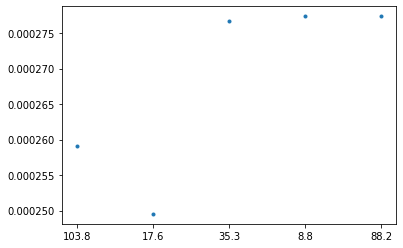

In [80]:
v_list = ['103.8', '17.6', '35.3', '8.8', '88.2']

# Dict_gold = dict((k, fivemm_files[k][3:]) for k in v_list)
kappa_gold = []
for i, v in enumerate(list(gold_melting_W.keys())):
    power = [float(j) for j in power_used[v]][:-1]
    y = dRoverR_1[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.00000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_gold_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(gold_melting_W[v], *popt)
    gold_m = 1064
    dT = gold_m - 21
    kappa = f / dT
    kappa_gold.append(kappa)
    
Dict_kappa_gold = dict(zip(list(gold_melting_W.keys()),kappa_gold))

plt.plot(list(gold_melting_W.keys()), kappa_gold, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_kappa.png", format="PNG")

In [81]:
peak_temp = []
for i, v in enumerate(list(gold_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_gold[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(gold_melting_W.keys()),peak_temp))

In [83]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(gold_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_16126/1710445269.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


ValueError: invalid literal for int() with base 10: '103.8'